In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot , plot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings('ignore')


### Reading the dataset and getting the info

In [46]:
df = pd.read_csv('heart.csv')

In [48]:
# Show Sample of Data
df.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
797,41,M,ASY,110,172,0,LVH,158,N,0.0,Up,1
327,59,M,ASY,125,0,1,Normal,119,Y,0.9,Up,1
622,59,M,ASY,110,239,0,LVH,142,Y,1.2,Flat,1
186,58,M,ATA,130,251,0,Normal,110,N,0.0,Up,0
369,63,M,ASY,150,0,0,Normal,86,Y,2.0,Flat,1


In [50]:
# Show Shape of Data
print(f"Number of Row : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")

Number of Row : 918
Number of Columns : 12


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [54]:
# Check NaN Value
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [56]:
# Describe Numiric Data
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


All this an errors in data collection¶
- the min value in 2 columns = 0 (RestingBP, Cholesterol) is not realistic
- An Oldpeak value of -2.6 mm is not realistic because ST depression (Oldpeak) cannot be negative

In [59]:
pd.DataFrame({'Count':df.shape[0],
              'Null':df.isnull().sum(),
              'Null %':df.isnull().mean() * 100,
              'Cardinality':df.nunique()
})

,Count,Null,Null %,Cardinality
Age,918,0,0.0,50
Sex,918,0,0.0,2
ChestPainType,918,0,0.0,4
RestingBP,918,0,0.0,67
Cholesterol,918,0,0.0,222
FastingBS,918,0,0.0,2
RestingECG,918,0,0.0,3
MaxHR,918,0,0.0,119
ExerciseAngina,918,0,0.0,2
Oldpeak,918,0,0.0,53


In [61]:
# Check Dublication
df.duplicated().sum()

0

### Handling missing data (Nulls)

##### Handle not realistic value (RestingBP, Cholesterol,Oldpeak)

The negative reviews are real but were entered incorrectly because Oldpeak should be positive

In [66]:
df[df['Oldpeak']<0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
321,63,M,ASY,100,0,1,Normal,109,N,-0.9,Flat,1
324,46,M,ASY,100,0,1,ST,133,N,-2.6,Flat,1
325,42,M,ASY,105,0,1,Normal,128,Y,-1.5,Down,1
326,45,M,NAP,110,0,0,Normal,138,N,-0.1,Up,0
331,56,M,ASY,115,0,1,ST,82,N,-1.0,Up,1
332,38,M,NAP,100,0,0,Normal,179,N,-1.1,Up,0
334,51,M,ASY,130,0,1,Normal,170,N,-0.7,Up,1
335,62,M,TA,120,0,1,LVH,134,N,-0.8,Flat,1
352,56,M,ASY,120,0,0,ST,100,Y,-1.0,Down,1
407,62,M,ASY,115,0,1,Normal,72,Y,-0.5,Flat,1


In [68]:
# Change negative values to positive values
df['Oldpeak'] = df['Oldpeak'].abs()

Convert those 0's values in these 2 columns (RestingBP, Cholesterol) to determine how many missing valuesin each feature in our data

In [71]:
df[['RestingBP','Cholesterol']] = df[['RestingBP','Cholesterol']].replace(0,np.nan)

In [73]:
# Show Number of Missing Values (NaN)
df[['RestingBP','Cholesterol']].isna().sum()

RestingBP        1
Cholesterol    172
dtype: int64

In [75]:
# Show Status of HeartDisease which NaN in RestingBP
df[df['RestingBP'].isna()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,NaN,NaN,0,Normal,155,N,1.5,Flat,1


In [77]:
# Fill Missing Value with median of people has Heart Disease
df['RestingBP'] = df['RestingBP'].fillna(df.groupby('HeartDisease')['RestingBP'].median()[1])

In [79]:
temp = df.groupby('HeartDisease')['Cholesterol'].median()
df.loc[(df['Cholesterol'].isna()) & (df['HeartDisease'] == 0), 'Cholesterol'] = temp[0]
df.loc[(df['Cholesterol'].isna()) & (df['HeartDisease'] == 1), 'Cholesterol'] = temp[1]

In [81]:
# After Fill Missing Values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Detection Outliers

In [85]:
def detect_outliers_iqr(df, columns, threshold = 1.5):

    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Finding outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers
    
    return outlier_indices

numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
outliers_iqr = detect_outliers_iqr(df, numerical_columns)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")

Age: 0 outliers detected
RestingBP: 27 outliers detected
Cholesterol: 41 outliers detected
MaxHR: 2 outliers detected
Oldpeak: 15 outliers detected


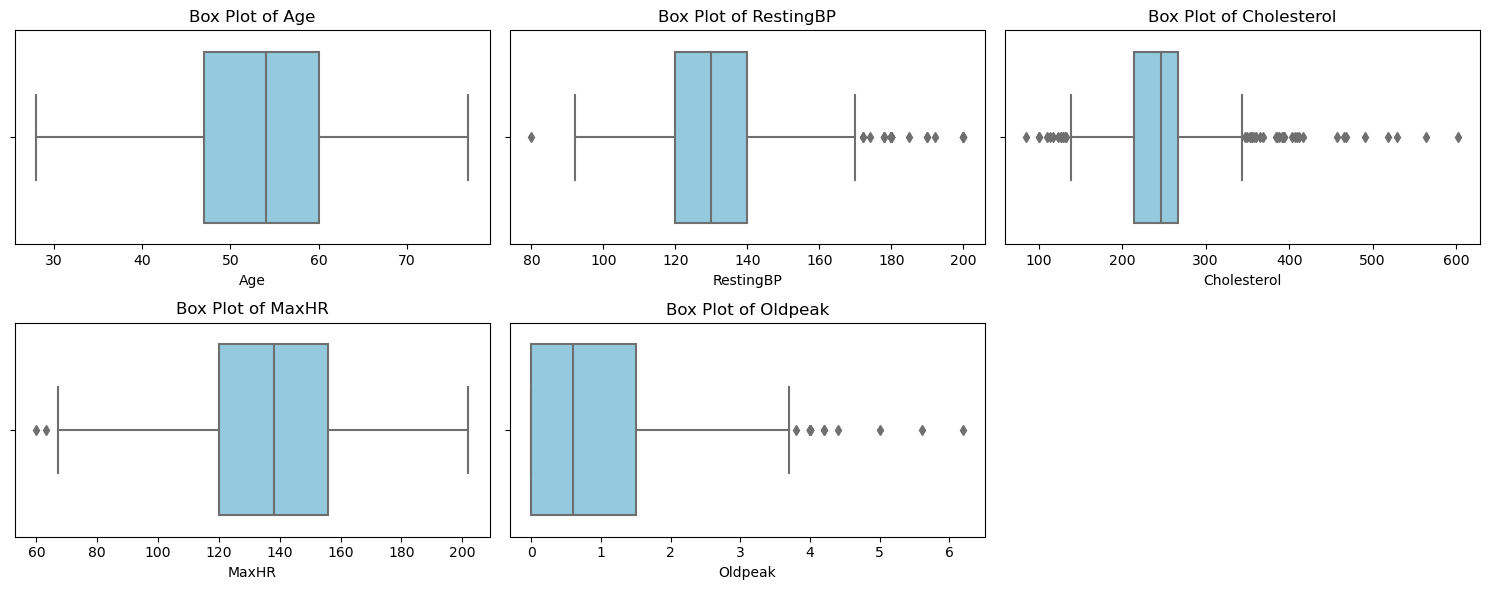

In [90]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [91]:
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)  # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    
    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)

In [92]:
# The New of Shape Cleaned Data
print(f"Number of Row : {df_cleaned.shape[0]}\nNumber of Columns : {df_cleaned.shape[1]}")

Number of Row : 824
Number of Columns : 12


##### Cleaned Data BoxPlot To Show Outliers

In [97]:
Import Needed Libraries
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot , plot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings('ignore')
Reading Dataset And Get Info
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
# Show Sample of Data
df.sample(5)
Age	Sex	ChestPainType	RestingBP	Cholesterol	FastingBS	RestingECG	MaxHR	ExerciseAngina	Oldpeak	ST_Slope	HeartDisease
22	49	F	ATA	124	201	0	Normal	164	N	0.0	Up	0
235	39	M	ATA	120	200	0	Normal	160	Y	1.0	Flat	0
61	43	F	NAP	150	254	0	Normal	175	N	0.0	Up	0
597	55	M	NAP	133	185	0	ST	136	N	0.2	Up	0
67	32	M	ATA	110	225	0	Normal	184	N	0.0	Up	0
# Show Shape of Data
print(f"Number of Row : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")
Number of Row : 918
Number of Columns : 12
df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
# Check NaN Value
df.isna().sum()
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
# Describe Numiric Data
df.describe()
Age	RestingBP	Cholesterol	FastingBS	MaxHR	Oldpeak	HeartDisease
count	918.000000	918.000000	918.000000	918.000000	918.000000	918.000000	918.000000
mean	53.510893	132.396514	198.799564	0.233115	136.809368	0.887364	0.553377
std	9.432617	18.514154	109.384145	0.423046	25.460334	1.066570	0.497414
min	28.000000	0.000000	0.000000	0.000000	60.000000	-2.600000	0.000000
25%	47.000000	120.000000	173.250000	0.000000	120.000000	0.000000	0.000000
50%	54.000000	130.000000	223.000000	0.000000	138.000000	0.600000	1.000000
75%	60.000000	140.000000	267.000000	0.000000	156.000000	1.500000	1.000000
max	77.000000	200.000000	603.000000	1.000000	202.000000	6.200000	1.000000
All this an errors in data collection
the min value in 2 columns = 0 (RestingBP, Cholesterol) is not realistic
An Oldpeak value of -2.6 mm is not realistic because ST depression (Oldpeak) cannot be negative
pd.DataFrame({'Count':df.shape[0],
              'Null':df.isnull().sum(),
              'Null %':df.isnull().mean() * 100,
              'Cardinality':df.nunique()
})
Count	Null	Null %	Cardinality
Age	918	0	0.0	50
Sex	918	0	0.0	2
ChestPainType	918	0	0.0	4
RestingBP	918	0	0.0	67
Cholesterol	918	0	0.0	222
FastingBS	918	0	0.0	2
RestingECG	918	0	0.0	3
MaxHR	918	0	0.0	119
ExerciseAngina	918	0	0.0	2
Oldpeak	918	0	0.0	53
ST_Slope	918	0	0.0	3
HeartDisease	918	0	0.0	2
# Check Dublication
df.duplicated().sum()
0
Handling Missing Data (Nulls)
Handle not realistic value (RestingBP, Cholesterol,Oldpeak)
The negative reviews are real but were entered incorrectly because Oldpeak should be positive
df[df['Oldpeak']<0]
Age	Sex	ChestPainType	RestingBP	Cholesterol	FastingBS	RestingECG	MaxHR	ExerciseAngina	Oldpeak	ST_Slope	HeartDisease
321	63	M	ASY	100	0	1	Normal	109	N	-0.9	Flat	1
324	46	M	ASY	100	0	1	ST	133	N	-2.6	Flat	1
325	42	M	ASY	105	0	1	Normal	128	Y	-1.5	Down	1
326	45	M	NAP	110	0	0	Normal	138	N	-0.1	Up	0
331	56	M	ASY	115	0	1	ST	82	N	-1.0	Up	1
332	38	M	NAP	100	0	0	Normal	179	N	-1.1	Up	0
334	51	M	ASY	130	0	1	Normal	170	N	-0.7	Up	1
335	62	M	TA	120	0	1	LVH	134	N	-0.8	Flat	1
352	56	M	ASY	120	0	0	ST	100	Y	-1.0	Down	1
407	62	M	ASY	115	0	1	Normal	72	Y	-0.5	Flat	1
413	56	M	NAP	125	0	1	Normal	98	N	-2.0	Flat	1
421	66	M	NAP	120	0	0	ST	120	N	-0.5	Up	0
512	35	M	NAP	123	161	0	ST	153	N	-0.1	Up	0
# Change negative values to positive values
df['Oldpeak'] = df['Oldpeak'].abs()
Convert those 0's values in these 2 columns (RestingBP, Cholesterol) to determine how many missing valuesin each feature in our data
df[['RestingBP','Cholesterol']] = df[['RestingBP','Cholesterol']].replace(0,np.nan)
# Show Number of Missing Values (NaN)
df[['RestingBP','Cholesterol']].isna().sum()
RestingBP        1
Cholesterol    172
dtype: int64
# Show Status of HeartDisease which NaN in RestingBP
df[df['RestingBP'].isna()]
Age	Sex	ChestPainType	RestingBP	Cholesterol	FastingBS	RestingECG	MaxHR	ExerciseAngina	Oldpeak	ST_Slope	HeartDisease
449	55	M	NAP	NaN	NaN	0	Normal	155	N	1.5	Flat	1
# Fill Missing Value with median of people has Heart Disease
df['RestingBP'] = df['RestingBP'].fillna(df.groupby('HeartDisease')['RestingBP'].median()[1])
temp = df.groupby('HeartDisease')['Cholesterol'].median()
df.loc[(df['Cholesterol'].isna()) & (df['HeartDisease'] == 0), 'Cholesterol'] = temp[0]
df.loc[(df['Cholesterol'].isna()) & (df['HeartDisease'] == 1), 'Cholesterol'] = temp[1]
# After Fill Missing Values
df.isnull().sum()
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Detection Outliers
def detect_outliers_iqr(df, columns, threshold = 1.5):

    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Finding outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers
    
    return outlier_indices

numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
outliers_iqr = detect_outliers_iqr(df, numerical_columns)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")
Age: 0 outliers detected
RestingBP: 27 outliers detected
Cholesterol: 41 outliers detected
MaxHR: 2 outliers detected
Oldpeak: 15 outliers detected
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)  # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    
    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)
# The New of Shape Cleaned Data
print(f"Number of Row : {df_cleaned.shape[0]}\nNumber of Columns : {df_cleaned.shape[1]}")
Number of Row : 824
Number of Columns : 12
Cleaned Data BoxPlot To Show Outliers
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i) 
    sns.boxplot(x = df_cleaned[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

SyntaxError: unterminated string literal (detected at line 124) (3791863233.py, line 124)